# Dutch primary school CET score
 
## Overview

In the Netherland  children go to primary school on the next day after they turn 4 years old. And before that parents should choose the best fitting school for their baby. I think that the best school for my baby should have a lot of charactheristic and also has an ability to give my baby a good knowlegde, so he could get a good score in the final exam to continue education in secondary school. I found that Dutch Ministry of education, culture and science open some of their data, so I collected them into dataset from https://duo.nl/open_onderwijsdata/databestanden/ and now I want to analyse what I have there. Ideally I also want to find is it possible to calcuate the quality of the education which school can give to students based on this data or we need some extra data to define this?
One of the main factor that could define the quality of education is final exams score, I will analyse it first. First of all I want to know what does CET score depend on and how it defines by other factors. To solve this problem first I read the dataset from the file Score.csv and get data from the most last year we have(2018), will clean it, will make new feature which would means the level of the average CET score for each school. As a result I will try to build classifier for those CET score levels to be able predict "how good" the exam result will be depending on other parameters we have. I also will use a few algorithms to build a clafssifier and see which geaves us better results.

## Data preparation

Let's start with reading dataset from the file 'Score.csv' and only data from one year (for example, 2018):

In [42]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data_score = pd.read_csv("Score.csv", error_bad_lines=False, sep=',', encoding = "ISO-8859-1") 
data_score = data_score[data_score['DATUM'] == 2018]
print(data_score.shape)
print(data_score.columns)
data_score.head()

(6286, 37)
Index(['SCHOOL_ID', 'DATUM', 'INSTELLINGSNAAM_VESTIGING', 'POSTCODE_VESTIGING',
       'PLAATSNAAM', 'GEMEENTENUMMER', 'GEMEENTENAAM', 'PROVINCIE', 'SOORT_PO',
       'DENOMINATIE_VESTIGING', 'BEVOEGD_GEZAG_NUMMER',
       'AANTAL_LEERLINGEN_EXAMEN', 'EXAMEN', 'EXAMEN_AANTAL', 'EXAMEN_GEM',
       'REKENEN_LAGER1F', 'REKENEN_1F', 'REKENEN_1S', 'REKENEN_2F',
       'LV_LAGER1F', 'LV_1F', 'LV_2F', 'TV_LAGER1F', 'TV_1F', 'TV_2F', 'VSO',
       'PRO', 'VMBO', 'VMBO_HAVO', 'HAVO', 'HAVO_VWO', 'VWO',
       'ADVIES_NIET_MOGELIJK', 'TOTAAL_ADVIES', 'LJ8', 'ZIT', 'ZITPERC'],
      dtype='object')


,SCHOOL_ID,DATUM,INSTELLINGSNAAM_VESTIGING,POSTCODE_VESTIGING,PLAATSNAAM,GEMEENTENUMMER,GEMEENTENAAM,PROVINCIE,SOORT_PO,DENOMINATIE_VESTIGING,...,VMBO,VMBO_HAVO,HAVO,HAVO_VWO,VWO,ADVIES_NIET_MOGELIJK,TOTAAL_ADVIES,LJ8,ZIT,ZITPERC
18739,000AP_2018,2018,De Schanskorf,2715BT,ZOETERMEER,637,Zoetermeer,Zuid-Holland,Bo,Gereformeerd vrijgemaakt,...,0,2,4,0,3,0,11,11,1,9.090909
18740,000AR_2018,2018,"BS ""De Maasparel""",6107AW,STEVENSWEERT,1641,Maasgouw,Limburg,Bo,Rooms-Katholiek,...,1,0,4,0,9,0,17,17,1,5.882353
18741,000AV_2018,2018,De Morgenster,3201CN,SPIJKENISSE,1930,Nissewaard,Zuid-Holland,Bo,Gereformeerd vrijgemaakt,...,0,3,1,3,2,0,12,12,1,8.333333
18742,000AZ_2018,2018,De Stapsteen,2971AR,BLESKENSGRAAF CA,1927,Molenwaard,Zuid-Holland,Bo,Openbaar,...,1,5,3,0,3,0,15,14,2,14.285714
18743,000BB_2018,2018,Obs Letterwies,9944AR,NIEUWOLDA,1895,Oldambt,Groningen,Bo,Openbaar,...,5,2,4,1,2,0,21,11,1,9.090909


I want to create new variable which would means how well students of particular school take the exam. We have a few exams chosen by schools, let's take a look at it:

In [43]:
data_score['EXAMEN'].value_counts()

CET       3527
IEP       1790
ROUTE8     833
DIA         83
AMN         53
Name: EXAMEN, dtype: int64

I will create new variable 'SCORE_TYPE' with values 'low' and 'high' depends on score and on the chosen exam, because average score is different for different exams:

In [44]:
def get_type_score(row): 
    result = "Low"
    exam_data = data_score[data_score['EXAMEN'] == row.EXAMEN]
    if(row.EXAMEN_GEM < exam_data['EXAMEN_GEM'].median()):
        result = "Low"
    else:
        result = "High"
    return result

data_score['SCORE_LEVEL'] =  data_score.apply(lambda row: get_type_score(row), axis = 1)

In [45]:
print(data_score['SCORE_LEVEL'].value_counts())

High    3146
Low     3140
Name: SCORE_LEVEL, dtype: int64


Next I want to remove unnecessary columns because some of them is higly correlated (like few columns which describe an address of school, we can leave only one of them) and some of them we just don't need (like 'SCHOOL_ID' or 'BEVOEGD_GEZAG_NUMMER') or they mean same thing as outcome (like score variable 'EXAMEN_GEM'):

In [46]:
columns = ['EXAMEN_GEM', 'SCHOOL_ID', 'DATUM', 'INSTELLINGSNAAM_VESTIGING', 'POSTCODE_VESTIGING', 'PLAATSNAAM', 'GEMEENTENAAM', 
           'PROVINCIE', 'BEVOEGD_GEZAG_NUMMER', 'ZITPERC']
print(data_score.shape)
data = data_score.drop(columns, 1)
print(data.shape)
print(data.columns)
data.head()

(6286, 38)
(6286, 28)
Index(['GEMEENTENUMMER', 'SOORT_PO', 'DENOMINATIE_VESTIGING',
       'AANTAL_LEERLINGEN_EXAMEN', 'EXAMEN', 'EXAMEN_AANTAL',
       'REKENEN_LAGER1F', 'REKENEN_1F', 'REKENEN_1S', 'REKENEN_2F',
       'LV_LAGER1F', 'LV_1F', 'LV_2F', 'TV_LAGER1F', 'TV_1F', 'TV_2F', 'VSO',
       'PRO', 'VMBO', 'VMBO_HAVO', 'HAVO', 'HAVO_VWO', 'VWO',
       'ADVIES_NIET_MOGELIJK', 'TOTAAL_ADVIES', 'LJ8', 'ZIT', 'SCORE_LEVEL'],
      dtype='object')


,GEMEENTENUMMER,SOORT_PO,DENOMINATIE_VESTIGING,AANTAL_LEERLINGEN_EXAMEN,EXAMEN,EXAMEN_AANTAL,REKENEN_LAGER1F,REKENEN_1F,REKENEN_1S,REKENEN_2F,...,VMBO,VMBO_HAVO,HAVO,HAVO_VWO,VWO,ADVIES_NIET_MOGELIJK,TOTAAL_ADVIES,LJ8,ZIT,SCORE_LEVEL
18739,637,Bo,Gereformeerd vrijgemaakt,11,CET,11,1,5,5,0,...,0,2,4,0,3,0,11,11,1,High
18740,1641,Bo,Rooms-Katholiek,17,CET,17,0,5,12,0,...,1,0,4,0,9,0,17,17,1,High
18741,1930,Bo,Gereformeerd vrijgemaakt,11,CET,11,1,5,5,0,...,0,3,1,3,2,0,12,12,1,Low
18742,1927,Bo,Openbaar,12,IEP,12,2,3,7,0,...,1,5,3,0,3,0,15,14,2,High
18743,1895,Bo,Openbaar,21,CET,21,1,14,6,0,...,5,2,4,1,2,0,21,11,1,Low


Let's take a look at the outcome:

High    3146
Low     3140
Name: SCORE_LEVEL, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


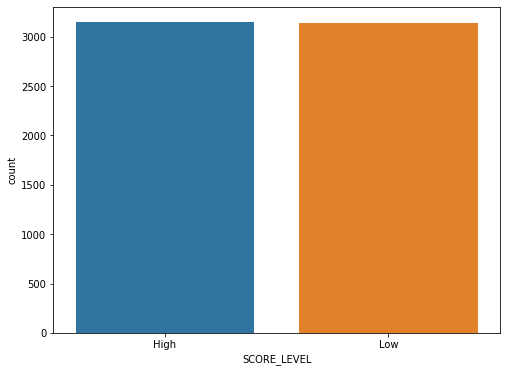

In [47]:
print(data['SCORE_LEVEL'].value_counts())
plt.figure(figsize=(8,6))
print(sns.countplot(x='SCORE_LEVEL',data=data, 
                    order = data['SCORE_LEVEL'].value_counts().index))

The outcome ('SCORE_LEVEL' column) values have almost the same amount of values, so we don't need to do anything with this sample (like oversampling or undersampling) and just continue with analysis. 
Let's encode categorical variables using LabelEncoder:

In [48]:
from sklearn.preprocessing import LabelEncoder

data['SOORT_PO'] = LabelEncoder().fit_transform(data['SOORT_PO'])

data['DENOMINATIE_VESTIGING'] = LabelEncoder().fit_transform(data['DENOMINATIE_VESTIGING'])

data['EXAMEN'] = LabelEncoder().fit_transform(data['EXAMEN'])

data['SCORE_LEVEL'] = LabelEncoder().fit_transform(data['SCORE_LEVEL'])
data.head()

,GEMEENTENUMMER,SOORT_PO,DENOMINATIE_VESTIGING,AANTAL_LEERLINGEN_EXAMEN,EXAMEN,EXAMEN_AANTAL,REKENEN_LAGER1F,REKENEN_1F,REKENEN_1S,REKENEN_2F,...,VMBO,VMBO_HAVO,HAVO,HAVO_VWO,VWO,ADVIES_NIET_MOGELIJK,TOTAAL_ADVIES,LJ8,ZIT,SCORE_LEVEL
18739,637,0,4,11,1,11,1,5,5,0,...,0,2,4,0,3,0,11,11,1,0
18740,1641,0,12,17,1,17,0,5,12,0,...,1,0,4,0,9,0,17,17,1,0
18741,1930,0,4,11,1,11,1,5,5,0,...,0,3,1,3,2,0,12,12,1,1
18742,1927,0,9,12,3,12,2,3,7,0,...,1,5,3,0,3,0,15,14,2,0
18743,1895,0,9,21,1,21,1,14,6,0,...,5,2,4,1,2,0,21,11,1,1


Now we can start modelling, but first we need to normalize data (using MinMaxScaler) and split it on train and test data:

In [49]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import  plot_roc_curve

random_state = 4004

def split_data(data): 
    
    X_train, X_test, y_train, y_test = train_test_split(data, pred, train_size=0.7, test_size=0.3, random_state=random_state)
    return X_train, X_test, y_train, y_test

pred = data['SCORE_LEVEL']
data.drop('SCORE_LEVEL', 1, inplace = True)
    
X_train, X_test, y_train, y_test = split_data(data)

## Building models

Let' start modelling. I will built classification model using a several ML algorithms: Random forest, K Nearest Neighbors, Support Vector Machine and XGBoost. 

### Random forest

In [50]:
def random_forest(X_train, X_test, y_train, y_test):
    rfc = RandomForestClassifier(n_estimators=100, random_state = random_state)
    rfc.fit(X_train, y_train)
    pred_test = rfc.predict(X_test)
 
    rfc_score = 100 * rfc.score(X_test, y_test)
    print("Score is: %3.2f" % (rfc_score))
    
    rfc_disp = plot_roc_curve(rfc, X_test, y_test)
    return rfc, rfc_score, rfc_disp

Random Forest
Score is: 88.92


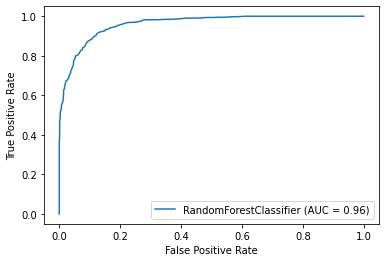

In [51]:
print("Random Forest")
rfc, rfc_score, rfc_disp = random_forest(X_train, X_test, y_train, y_test)

### K Nearest Neighbors 

In [52]:
def knn(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    pred_test = knn.predict(X_test)
    knn_score = 100 * knn.score(X_test, y_test)
    print("Score is: %3.2f" % (knn_score))
    knn_disp = plot_roc_curve(knn, X_test, y_test)
    return knn, knn_score, knn_disp

KNN
Score is: 72.80


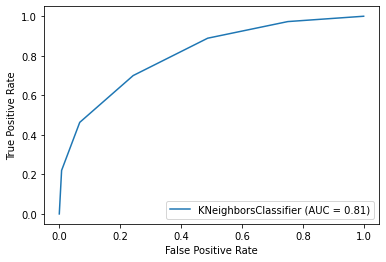

In [53]:
print("KNN")
knn, knn_score, knn_disp = knn(X_train, X_test, y_train, y_test)

### Support Vector Machine

In [54]:
def svc(X_train, X_test, y_train, y_test):
    svc = SVC()
    svc.fit(X_train, y_train)
    pred_test = svc.predict(X_test)
    svc_score = 100 * svc.score(X_test, y_test)
    print("Score is: %3.2f" % (svc_score))
    svc_disp = plot_roc_curve(svc, X_test, y_test)
    return svc, svc_score, svc_disp

In [ ]:
print("Support Vector Machine")
svc, svc_score, svc_disp = svc(X_train, X_test, y_train, y_test)

Support Vector Machine


### XGBoost

In [ ]:
def XGBoost(X_train, X_test, y_train, y_test):
    xgb = XGBClassifier(n_estimators=100)
    xgb.fit(X_train, y_train)
    pred_test = xgb.predict(X_test)
    xgb_score = (pred_test == y_test).sum() / len(pred_test)*100
    print("Score is: %3.2f" % (xgb_score))
    xgb_disp = plot_roc_curve(xgb, X_test, y_test)
    return xgb, xgb_score, xgb_disp

In [ ]:
print("XGBoost")
xgb, xgb_score, xgb_disp = XGBoost(X_train, X_test, y_train, y_test)

## Results

We made a few models, let's check which one gave more accurate results:

In [ ]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'KNN', 'SVC', 'XGBoost'],
    'Score': [rfc_score, knn_score, svc_score, xgb_score]
}).sort_values(by='Score', ascending=False).set_index('Model')
results

In [ ]:
#roc plot
ax = plt.gca()
rfc_disp.plot(ax=ax, alpha=0.8)
knn_disp.plot(ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
xgb_disp.plot(ax=ax, alpha=0.8)
plt.show()

We can see that XGBoost and Random forest gave us almost the same result.
Let's check now what factors was the most important:

In [ ]:
importances = pd.DataFrame({
    'Feature': data.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False).set_index('Feature')
importances.plot.bar()

It looks like the most important factors are amount of students who doesn't have enough math skills and those who has good language skills.

### Conclusion

As a result I can say that for prediction the level of CET exam XGBoost gives the better result. 
Also when I will choose the school with better then average quality of education, I need to take a look at number of student, who knows math not very well (and probably the smallest amount of such atudents, the better average CET score school would have).